# Extra bonus task

- Repeat problem 2 and 3 for car accessibility! No extra points available for this, but you can for example start thinking if you want to make the final assignment related to this topic :)

In [51]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

directory = r"exercise-4-main/data"
grid_file = r"MetropAccess_YKR_grid_EurefFIN.shp"
grid_path = os.path.join(directory, grid_file)


list_of_files = os.listdir(directory)
list_of_travel_time_files = []

for file in list_of_files:
    if '.txt' in file:
        list_of_travel_time_files.append(os.path.join(directory, file))

print(list_of_travel_time_files, " length of: ", len(list_of_travel_time_files) )

['exercise-4-main/data\\TravelTimes_to_5878070_Jumbo.txt', 'exercise-4-main/data\\TravelTimes_to_5878087_Dixi.txt', 'exercise-4-main/data\\TravelTimes_to_5902043_Myyrmanni.txt', 'exercise-4-main/data\\TravelTimes_to_5944003_Itis.txt', 'exercise-4-main/data\\TravelTimes_to_5975373_Forum.txt', 'exercise-4-main/data\\TravelTimes_to_5978593_IsoOmena.txt', 'exercise-4-main/data\\TravelTimes_to_5980260_Ruoholahti.txt']  length of:  7


- Extract shopping center district names

In [52]:
#example of extracting shopping center name from string using regex
#https://docs.python.org/3/library/re.html

shopping_center_names_list = []

#repeat for all shopping centers
for shopping_center in list_of_travel_time_files:
    shopping_center_names_list.append( shopping_center.split('_')[3][:-4] )

print(shopping_center_names_list)

['Jumbo', 'Dixi', 'Myyrmanni', 'Itis', 'Forum', 'IsoOmena', 'Ruoholahti']


- Table join grid and travel times table for each shopping district

In [53]:
#read in grid shapefile
grid = gpd.read_file(grid_path)

#read each txt file as a data frame store in the list
for file, shopping_center in zip(list_of_travel_time_files, shopping_center_names_list):
    
    data = pd.read_csv(file, sep=';') 
    
    #generate new column name
    title_string = 'car_r_t_{val}'.format(val = shopping_center)
    
    #create a new column using values from the 'pt_r_t' column
    data[title_string] = data[ [ 'car_r_t' ] ] 
    
    data.drop(columns=['car_r_t'], axis=1, inplace=True)
    
    #create a smaller subset of data, join both tables using YKR_ID from grid and from_id of data, overwrite the previous dataframe
    grid = grid.merge(data[ [title_string, 'from_id'] ],  how='outer', left_on = 'YKR_ID', right_on ='from_id')
    
    grid.drop(columns = ['from_id'], axis=1, inplace=True)

- Transform CRS of grid geodataframe
- Transform CRS of travel times data frame

In [54]:
from pyproj import CRS

#transform the crs of grid shapefile before performing the aggregation of geometry features by dominant shopping center
#this grid shapefile is important for the next exercise
grid = grid.to_crs(CRS.from_epsg(3879))

In [55]:
# NON-EDITABLE TEST CELL
#Check input grid
print(grid.head())

          x          y   YKR_ID  \
0  381875.0  6697880.0  5785640   
1  382125.0  6697880.0  5785641   
2  382375.0  6697880.0  5785642   
3  382625.0  6697880.0  5785643   
4  381125.0  6697630.0  5787544   

                                            geometry  car_r_t_Jumbo  \
0  POLYGON ((25492192.647 6698519.964, 25491942.7...             39   
1  POLYGON ((25492442.589 6698527.553, 25492192.6...             39   
2  POLYGON ((25492692.532 6698535.142, 25492442.5...             45   
3  POLYGON ((25492942.475 6698542.731, 25492692.5...             46   
4  POLYGON ((25491450.410 6698247.254, 25491200.4...             38   

   car_r_t_Dixi  car_r_t_Myyrmanni  car_r_t_Itis  car_r_t_Forum  \
0            45                 39            50             49   
1            45                 39            51             49   
2            52                 47            58             57   
3            48                 51            57             60   
4            44            

In [56]:
# NON-EDITABLE TEST CELL
#Check data
print(grid.head())

# Check that there are correct number of columns
assert len(grid.columns) >= 9, "There are some columns missing from the grid."

          x          y   YKR_ID  \
0  381875.0  6697880.0  5785640   
1  382125.0  6697880.0  5785641   
2  382375.0  6697880.0  5785642   
3  382625.0  6697880.0  5785643   
4  381125.0  6697630.0  5787544   

                                            geometry  car_r_t_Jumbo  \
0  POLYGON ((25492192.647 6698519.964, 25491942.7...             39   
1  POLYGON ((25492442.589 6698527.553, 25492192.6...             39   
2  POLYGON ((25492692.532 6698535.142, 25492442.5...             45   
3  POLYGON ((25492942.475 6698542.731, 25492692.5...             46   
4  POLYGON ((25491450.410 6698247.254, 25491200.4...             38   

   car_r_t_Dixi  car_r_t_Myyrmanni  car_r_t_Itis  car_r_t_Forum  \
0            45                 39            50             49   
1            45                 39            51             49   
2            52                 47            58             57   
3            48                 51            57             60   
4            44            

- For each population grid cell (each row), find out the shortest car travel time to any shopping center. Store the result in a new column 'min_t'.
- Find out also the column name (for example: 'car_r_t_Jumbo'), for the shortest car travel time using the idxmin() function into a column called 'dominant_service'

In [57]:
columns_for_comparison = grid.columns[4:]

#extract the min value from current row
row_min =  grid[ columns_for_comparison ].idxmin(axis='columns',skipna=True)

#test row_min
print(len(row_min))

dominant_service = []
min_t = []
for index in range(0,len(row_min)):
    min_t.append( grid.at[index, row_min[index]] )
    dominant_service.append( row_min[index].split('_')[3])

grid['min_t'] = min_t
grid['dominant_service'] = dominant_service

13231


In [58]:
grid.head()

,x,y,YKR_ID,geometry,car_r_t_Jumbo,car_r_t_Dixi,car_r_t_Myyrmanni,car_r_t_Itis,car_r_t_Forum,car_r_t_IsoOmena,car_r_t_Ruoholahti,min_t,dominant_service
0,381875.0,6697880.0,5785640,"POLYGON ((25492192.647 6698519.964, 25491942.7...",39,45,39,50,49,56,56,39,Jumbo
1,382125.0,6697880.0,5785641,"POLYGON ((25492442.589 6698527.553, 25492192.6...",39,45,39,51,49,56,56,39,Jumbo
2,382375.0,6697880.0,5785642,"POLYGON ((25492692.532 6698535.142, 25492442.5...",45,52,47,58,57,64,63,45,Jumbo
3,382625.0,6697880.0,5785643,"POLYGON ((25492942.475 6698542.731, 25492692.5...",46,48,51,57,60,67,67,46,Jumbo
4,381125.0,6697630.0,5787544,"POLYGON ((25491450.410 6698247.254, 25491200.4...",38,44,38,50,48,55,55,38,Jumbo


- Remove rows containing -1 (no data values) from the dataframe. You can for example replace the no-data values with numpy's np.nan, and then drop no-data values using the DataFrame.dropna function.

In [59]:
import numpy as np

#more efficient way of removing null values from dataframe
grid.replace(-1, np.nan, inplace=True)

#drop NA values if there any NA values in thw row, do not make a copy of the instance.
grid.dropna(axis=0, how='any', inplace=True)

grid.reset_index( inplace=True)

print("simplified NA removal: " , len(grid))

simplified NA removal:  13140


In [60]:
# NON-EDITABLE TEST CELL
print(grid[['YKR_ID', 'min_t', 'dominant_service']].head())

    YKR_ID  min_t dominant_service
0  5785640   39.0            Jumbo
1  5785641   39.0            Jumbo
2  5785642   45.0            Jumbo
3  5785643   46.0            Jumbo
4  5787544   38.0            Jumbo


- aggregate grid polygons into 7 multipolygons

In [61]:
#dissolve (aggregate geometries - municipality polygon geometries for each shopping center
dominant_service_area = grid.dissolve(by='dominant_service')
    
dominant_service_area.reset_index(inplace=True)

#Select useful columns
dominant_service_area  = dominant_service_area[['dominant_service', "geometry"]]

Finally, visualize the dominance areas and travel times:

- visualize the dominance areas using the codes found in column dominant_service.
- Visualize travel times to shopping centers from the min_t column
  (You should create subplots with 2 rows and one column (see the example above).)

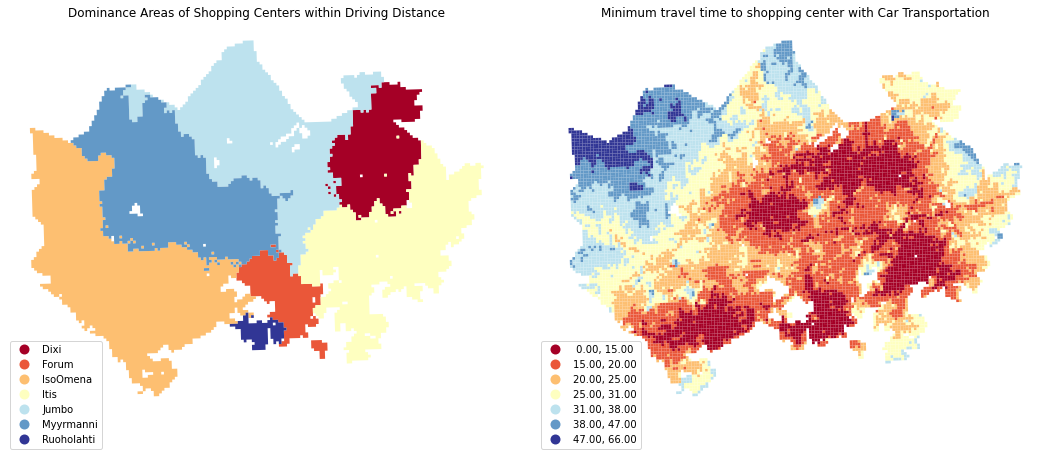

In [62]:
import matplotlib.pyplot as plt

#increase the overall figsize to allow the subplots to increase in fig_size
fig, axs = plt.subplots(nrows = 1, ncols=2, sharex=True, sharey=True, figsize= (15,15))


plot1 = dominant_service_area.plot(ax=axs[0], column='dominant_service',cmap="RdYlBu",k=7, linewidth=0, legend =True, figsize=(10, 5)) #plot a different color for each grid x 20 grids
plot1.set_title("Dominance Areas of Shopping Centers within Driving Distance")
plot1.axis('off')
leg1 = plot1.get_legend()
leg1.set_bbox_to_anchor((0., 0., 0.2, 0.2))

plot2 = grid.plot(ax = axs[1], column= "min_t", scheme= "Natural_Breaks", k=7, cmap="RdYlBu", linewidth=0, legend = True, figsize=(10, 5))
plot2.set_title("Minimum travel time to shopping center with Car Transportation")
plot2.axis('off')

leg2 = plot2.get_legend()
leg2.set_bbox_to_anchor((0., 0., 0.2, 0.2))

plt.tight_layout()
plt.show()

- Read in population data

In [63]:
import requests
import geojson

# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

In [64]:
# Change the name of a column
pop = pop.rename(columns={'asukkaita': 'pop18'})

# Check the column names
pop.columns

Index(['geometry', 'index', 'pop18', 'asvaljyys', 'ika0_9', 'ika10_19',
       'ika20_29', 'ika30_39', 'ika40_49', 'ika50_59', 'ika60_69', 'ika70_79',
       'ika_yli80'],
      dtype='object')

- Let’s also get rid of all unnecessary columns by selecting only columns that we need i.e. pop18 and geometry

In [65]:
# Subset columns
pop = pop[["pop18", "geometry"]]

pop.head()

,pop18,geometry
0,9,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,5,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
3,5,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
4,11,"POLYGON ((25472499.995 6682998.998, 25472499.9..."


- Verify CRS of both gdf before performing spatial join

In [66]:
print(dominant_service_area.crs)

epsg:3879


In [67]:
#check crs of population grid
print(pop.crs)

None


In [68]:
pop.crs = CRS.from_epsg(3879)
assert dominant_service_area.crs == pop.crs, "CRS of population and Grids are not equal"

- Join information between the population grid and the dominance areas -layer using intersect as the condition in the spatial join.

In [69]:
dominant_service_area.head()

,dominant_service,geometry
0,Dixi,"MULTIPOLYGON (((25499593.096 6685485.261, 2549..."
1,Forum,"MULTIPOLYGON (((25498714.595 6673199.974, 2549..."
2,IsoOmena,"MULTIPOLYGON (((25472380.160 6683659.312, 2547..."
3,Itis,"MULTIPOLYGON (((25497093.744 6677153.673, 2549..."
4,Jumbo,"MULTIPOLYGON (((25480582.117 6693664.456, 2548..."


In [70]:
#reference for sjoin: https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html

#inner join to preserve column attributes from both geodataframes, preserve the geometry of population grid
nearest_shopping_center= gpd.sjoin(pop, dominant_service_area, how='inner', predicate='intersects')

nearest_shopping_center.drop(columns=['index_right'], inplace=True)

nearest_shopping_center.head()

,pop18,geometry,dominant_service
0,9,"POLYGON ((25472499.995 6689749.005, 25472499.9...",IsoOmena
1,5,"POLYGON ((25472499.995 6685998.998, 25472499.9...",IsoOmena
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9...",IsoOmena
3,5,"POLYGON ((25472499.995 6683999.005, 25472499.9...",IsoOmena
4,11,"POLYGON ((25472499.995 6682998.998, 25472499.9...",IsoOmena


- Result

The total population near each shopping center district with minimum car travel time in 2018

In [71]:
nearest_shopping_center.groupby(by=['dominant_service']).sum()

,pop18
dominant_service,
Dixi,139377
Forum,206260
IsoOmena,235410
Itis,278293
Jumbo,113915
Myyrmanni,181994
Ruoholahti,39646


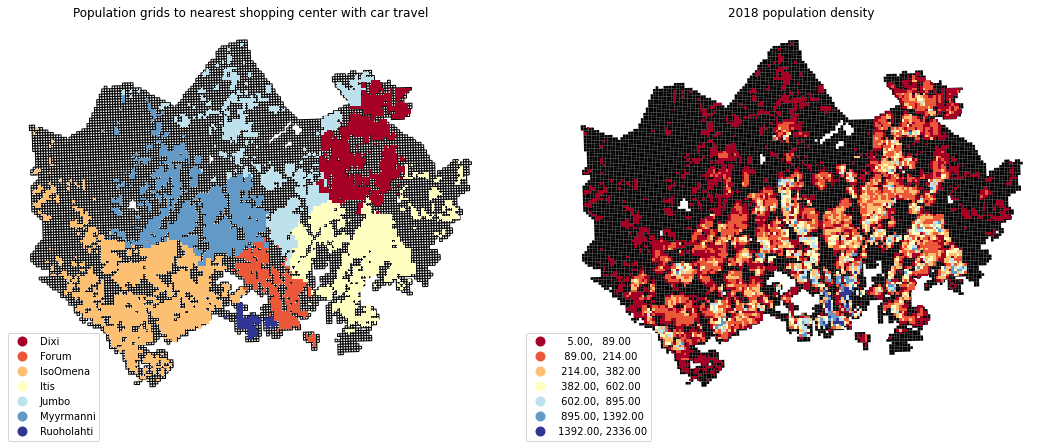

In [72]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

base = grid.plot(ax=axs[0], color='white', edgecolor='black')
plot1 = nearest_shopping_center.plot(ax=base, column='dominant_service', legend=True, cmap="RdYlBu", k=7)
plot1.set_title('Population grids to nearest shopping center with car travel')
plot1.axis('off')
leg1 = plot1.get_legend()
leg1.set_bbox_to_anchor((0., 0., 0.2, 0.2))

newbase = grid.plot(ax=axs[1], color='black')
plot2 = nearest_shopping_center.plot(ax=newbase, column= "pop18", scheme= "Natural_Breaks", k=7, cmap="RdYlBu", linewidth=0, legend =True,figsize=(10,5))
plot2.set_title('2018 population density')
plot2.axis('off')
leg2 = plot2.get_legend()
leg2.set_bbox_to_anchor((0., 0., 0.2, 0.2))

plt.tight_layout()

plt.show()